## GCN Testing:

Notebook to run trained GCN model on test data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

print(torch.__version__)
print(torch.version.cuda)

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

2.1.0
None


### Load Data:

In [2]:
data_path = './split_data/5_class_50yrN_split.pkl'
with open(data_path, 'rb') as f:
    # Load the serialized object from the file
    tune_data = pickle.load(f)

print(tune_data)

Data(x=[1000, 24], edge_index=[2, 100000], edge_attr=[100000, 1], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])


In [3]:
# Print the counts of each class in the test set:

test_labels = tune_data.y[tune_data.test_mask]

unique_classes, class_counts = torch.unique(test_labels, return_counts=True)

for cls, count in zip(unique_classes.tolist(), class_counts.tolist()):
    print(f"Class {cls}: {count} nodes in test set")

Class 0: 29 nodes in test set
Class 1: 34 nodes in test set
Class 2: 23 nodes in test set
Class 3: 34 nodes in test set
Class 4: 30 nodes in test set


### Define GCN Model and load saved state:

In [4]:
class GCN_Classifier(torch.nn.Module):
    '''GCN_Classifier Model'''

    # Define layers:
    def __init__(self, dim_in, dim_h, num_classes):
        super().__init__()
        self.conv1 = GCNConv(dim_in, dim_h, cached=True)
        self.conv2 = GCNConv(dim_h, num_classes, cached=True)

    # Define forward function:
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.1, training=self.training)
        h = self.conv2(h, edge_index)

        return h 

In [5]:
model_path = 'saved_models/GNN_best_model_5Classes_50yrN.pth'

dim_in = tune_data.num_features
dim_h = 128
num_classes = 5
model = GCN_Classifier(dim_in, dim_h, num_classes)

model.eval()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

### Define test function:

In [6]:
def test_model(model, data, num_classes, print_metrics=True):
    ''' 
    Function to test GNN and plot a confusion matrix

    Inputs:
    - model (torch.NN.Module): GNN model
    - data: Pytorch Geometric Data object
    - num_classes (int): Number of classes for classification
    - print_metrics (bool): Whether or not to print accuracy and confusion matrix

    Returns:
    - test_accuracy (float): Test accuracy of the model
    - raw_preds (float): Raw logits output from the model
    - labels: class labels for each sample
    '''

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        raw_preds = out[data.test_mask]
        pred = out.argmax(dim=1)
        test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        test_total = data.test_mask.sum().item()
        test_accuracy = test_correct / test_total
    
    if print_metrics:
        print('Test accuracy:', test_accuracy)

        # Convert prediction and label tensors to numpy arrays
        preds = pred[data.test_mask].cpu().numpy()
        labels = data.y[data.test_mask].cpu().numpy()

        # Build confusion matrix:
        if num_classes == 4:
            classes = ('1700', '1750', '1800', '1850')
        if num_classes == 5:
            classes = ('1650', '1700', '1750', '1800', '1850') 
        if num_classes == 10:
            classes = ('1650', '1675', '1700', '1725', '1750', '1775', '1800',  '1825', '1850', '1875')
        cf_matrix = confusion_matrix(labels, preds) # build confusion matrix
        cf_matrix_df = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes]) # normalise, convert to cols, store in dataframe 
        plt.figure(figsize = (12,7))
        plt.title('Folk-Song Dating Confusion Matrix')
        sn.heatmap(cf_matrix_df, annot=True)
    
    return test_accuracy, raw_preds, labels

### Test model:

Test accuracy: 0.5733333333333334


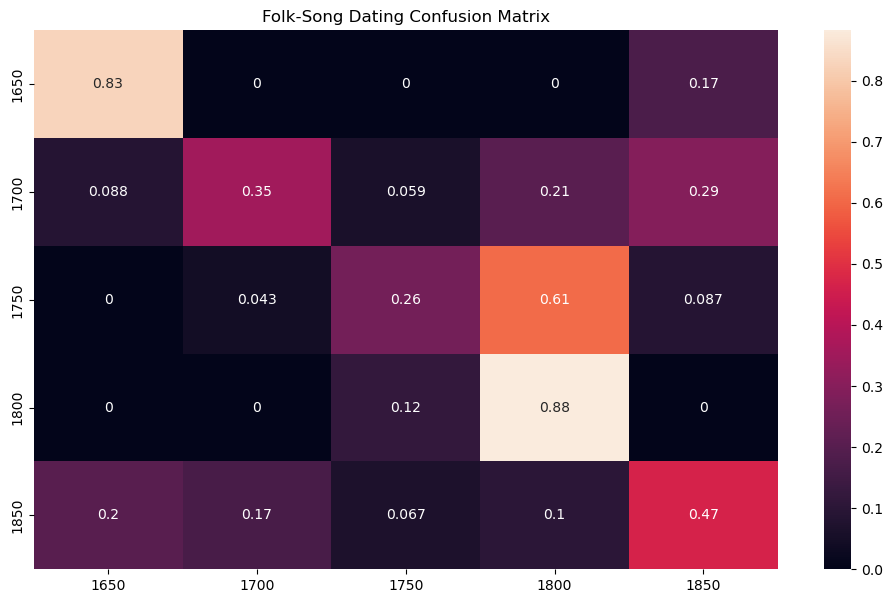

In [7]:
test_accuracy, preds, labels = test_model(model, tune_data, num_classes)

### Plot Latent Space:

In [3]:
from sklearn.manifold import TSNE
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
preds_np = preds.detach().numpy()

In [ ]:
# (Uncomment if needed):

# with open('./Dataset/GCN_preds_5Class.pkl', 'wb') as handle:
#     pickle.dump(preds_np, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./Dataset/GCN_true_labels_5Class.pkl', 'wb') as handle:
#     pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open('./Dataset/GCN_preds_5Class.pkl', 'rb') as handle:
    raw_preds = pickle.load(handle)

with open('./Dataset/GCN_true_labels_5Class.pkl', 'rb') as handle:
    true_labels = pickle.load(handle)

In [39]:
true_labels.shape

(150,)

In [40]:
type(raw_preds)

numpy.ndarray

In [41]:
raw_preds.shape

(150, 5)

In [78]:
tsne = TSNE(n_components=2, perplexity=18)
tsne_result = tsne.fit_transform(raw_preds)
tsne_result.shape

(150, 2)

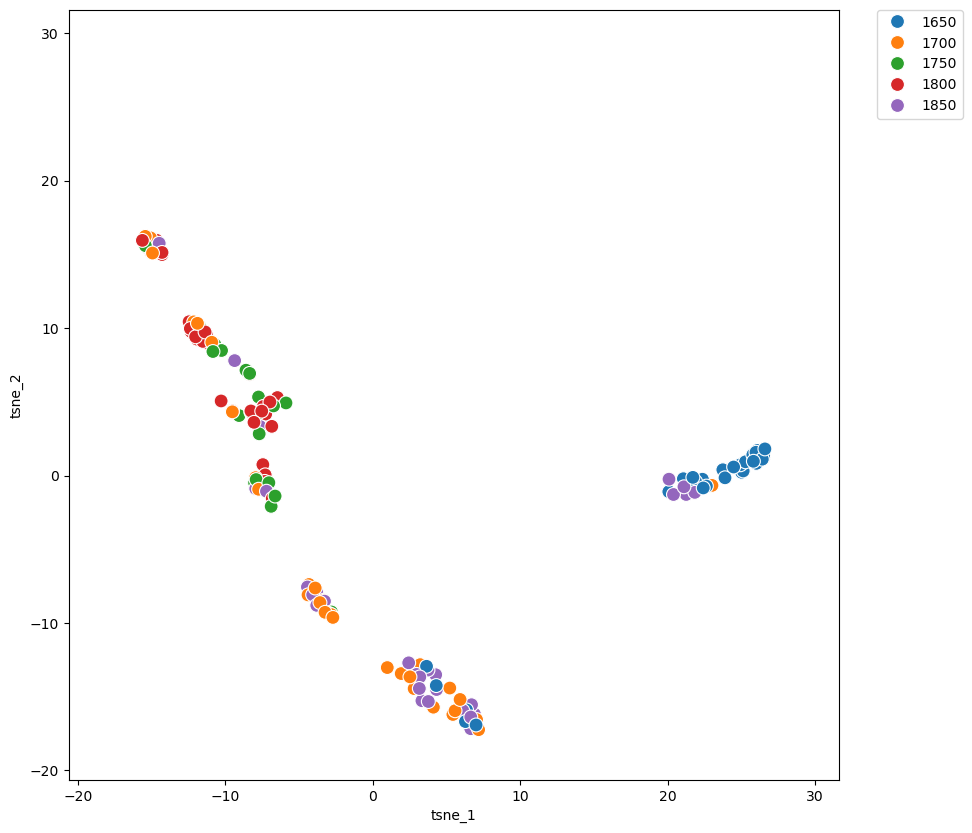

In [79]:
# Plot TSNE:

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': true_labels})
label_mapping = {
    0: '1650',
    1: '1700',
    2: '1750',
    3: '1800',
    4: '1850'
}
fig, ax = plt.subplots(1, figsize=(12,10))
palette = sns.color_palette("tab10", n_colors=len(tsne_result_df['label'].unique())) # Choose colours of labels
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, palette=palette, s=100)
lim = (tsne_result[:,0].min() - 5, tsne_result[:,0].max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_aspect('equal')

handles, labels = ax.get_legend_handles_labels()
custom_labels = [label_mapping[int(label)] for label in labels] # add a legend
ax.legend(handles=handles, labels=custom_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
